In [1]:
# Azure Data Lake libraries
import azure_data_lake_interface as adl

# Data analysis libraries
import pandas as pd
import sales_orders as so

# Helper function libraries
from helper_functions import load_config

In [2]:
# attach to the data lake
config = load_config("config/datalake_config.json", flush_cache=True)
service_client = adl.get_azure_service_client(config["blob_url"])
file_system_client = adl.get_azure_file_system_client(service_client, "consolidated")

In [3]:
items = adl.get_parquet_file_from_data_lake(file_system_client, "raw/netsuite", "item_raw.parquet")

In [6]:
items.to_csv("data/item_master_records.csv", index=False)

In [3]:
# get invoice data
invoices = adl.get_parquet_file_from_data_lake(file_system_client, "raw/netsuite", "transaction/CustInvc_raw.parquet")

In [4]:
# get local customer data
customers = pd.read_csv("data/active_customers.csv")

# change customer_id to string
customers["customer_id"] = customers["customer_id"].astype(str)

In [5]:
# change created_date to datetime and coerce all dates to datetime
invoices["created_date"] = pd.to_datetime(invoices["created_date"], errors="coerce")

# change strings to numeric
invoices["net_amount"] = pd.to_numeric(invoices["net_amount"], errors="coerce")
invoices["estimated_gross_profit"] = pd.to_numeric(invoices["estimated_gross_profit"], errors="coerce")
invoices["estimated_gross_profit_percent"] = pd.to_numeric(invoices["estimated_gross_profit_percent"], errors="coerce")

In [6]:
# Replace null values with replacement_value
invoices["location"] = invoices["location"].replace("null", "Not Specified")

In [7]:
# remove all rows outside the date range
start_date = "2022-01-01"
end_date = "2024-12-31"

invoices = invoices[(invoices["created_date"] >= start_date) & (invoices["created_date"] <= end_date)]

In [8]:
invoices["net_amount"].sum()

np.float64(634462087.21)

In [9]:
# add customer information to invoice_line_items
augmented_invoices = invoices.merge(customers[["customer_id", "subsidiary_name", "end_market", "sales_rep"]], on="customer_id", how="left")

In [10]:
augmented_invoices["subsidiary_name"].value_counts()

subsidiary_name
Allied Valve              84012
Allied Instrumentation    40609
Valve Sales Inc.          19319
Automation Service        16104
Name: count, dtype: int64

In [14]:
drop_list = ['links', 'actual_ship_date', 'ai_order_type', 'amount_paid',
       'amount_unpaid', 'billing_address', 'close_date', 'commission_only',
       'company_email', 'created_by',
       'custom_form', 'date_started', 'days_open',
       'deliver_by_date', 'due_date', 'employee', 'end_date',
       'entity_status', 'expected_close_date',
       'finance_charge', 'freshdesk_ticket_number', 'id', 'inbound_source',
       'job_type', 'last_modified_by', 'lastmodifieddate', 'lead_source',
       'mainline', 'memo', 'nexus', 'posting_period',
       'prepared_for_contact', 'prepared_for_contact_email', 'promised_date',
       'reversal', 'ship_date', 'shipping_address', 'start_date', 'status', 'total_cost_estimate',
        'tran_date', 'transaction_number','type', 'voided', 'custbody_nx_customer']

In [15]:
# drop all columns in drop list
augmented_invoices.drop(drop_list, axis=1, inplace=True)

In [17]:
# sort augmented_invoices by net amount largest to smallest
augmented_invoices.sort_values(by="net_amount", ascending=False, inplace=True)

In [18]:
augmented_invoices

,company_name,created_date,customer_id,entered_by,estimated_gross_profit,estimated_gross_profit_percent,location,net_amount,tranid,subsidiary_name,end_market,sales_rep
154993,Ovation Holding,2024-12-02,450508,Amanda Johnson,834746.32,1.000000,Corporate,834746.32,486194,Allied Valve,Reseller/Distributer,Not Assigned
137465,"Alfred Conhagen - Kenner, LA",2024-09-03,407641,Amanda Johnson,714126.38,1.000000,Corporate,714126.38,468525,Allied Valve,Upstream O&G,Distribution
124753,Worley Group (Jacobs),2024-06-25,10101,April Norris,174774.04,0.255892,Fenton,685568.00,455720,Allied Valve,Professional Services,Distribution
97400,WorleyParsons - Ontario,2024-01-30,51522,Stacie Comia,227762.40,0.357354,Joliet-AV Shop,637358.00,427938,Allied Valve,Professional Services,Distribution
153397,Worley Canada Services Ltd.,2024-11-22,439412,April Norris,221554.97,0.354880,Fenton,628332.22,484585,Allied Instrumentation,Midstream Liquid,Multiple
...,...,...,...,...,...,...,...,...,...,...,...,...
138505,"Atlas/Diversified - Deerfield, OH",2024-09-11,339496,Lorna Pepper,-83.22,0.000000,Kent,0.00,469592,Valve Sales Inc.,Upstream O&G,Wray Kilgore
93067,North East Pipe & Supply Inc.,2023-12-29,339609,Lorna Pepper,-90.93,0.000000,Kent,0.00,423585,Valve Sales Inc.,Reseller/Distributer,Joel Jenkins
24798,"Schneider Electric Systems USA, Inc",2022-10-05,62163,ASIS Integration,0.00,0.000000,St. Louis,0.00,354734,Automation Service,Manufacturing,Not Assigned
36173,"SABIC - Ottawa, IL",2023-01-04,8979,Matt Buettner,0.00,0.000000,Riverdale Shop,0.00,366212,Allied Valve,Chemical/Petrochem,Todd L White


In [19]:
# save locally and in the data lake
augmented_invoices.to_csv("data/invoice_totals.csv", index=False)
adl.save_df_as_parquet_in_data_lake(augmented_invoices, file_system_client, "enhanced/netsuite", "invoice_totals.parquet")

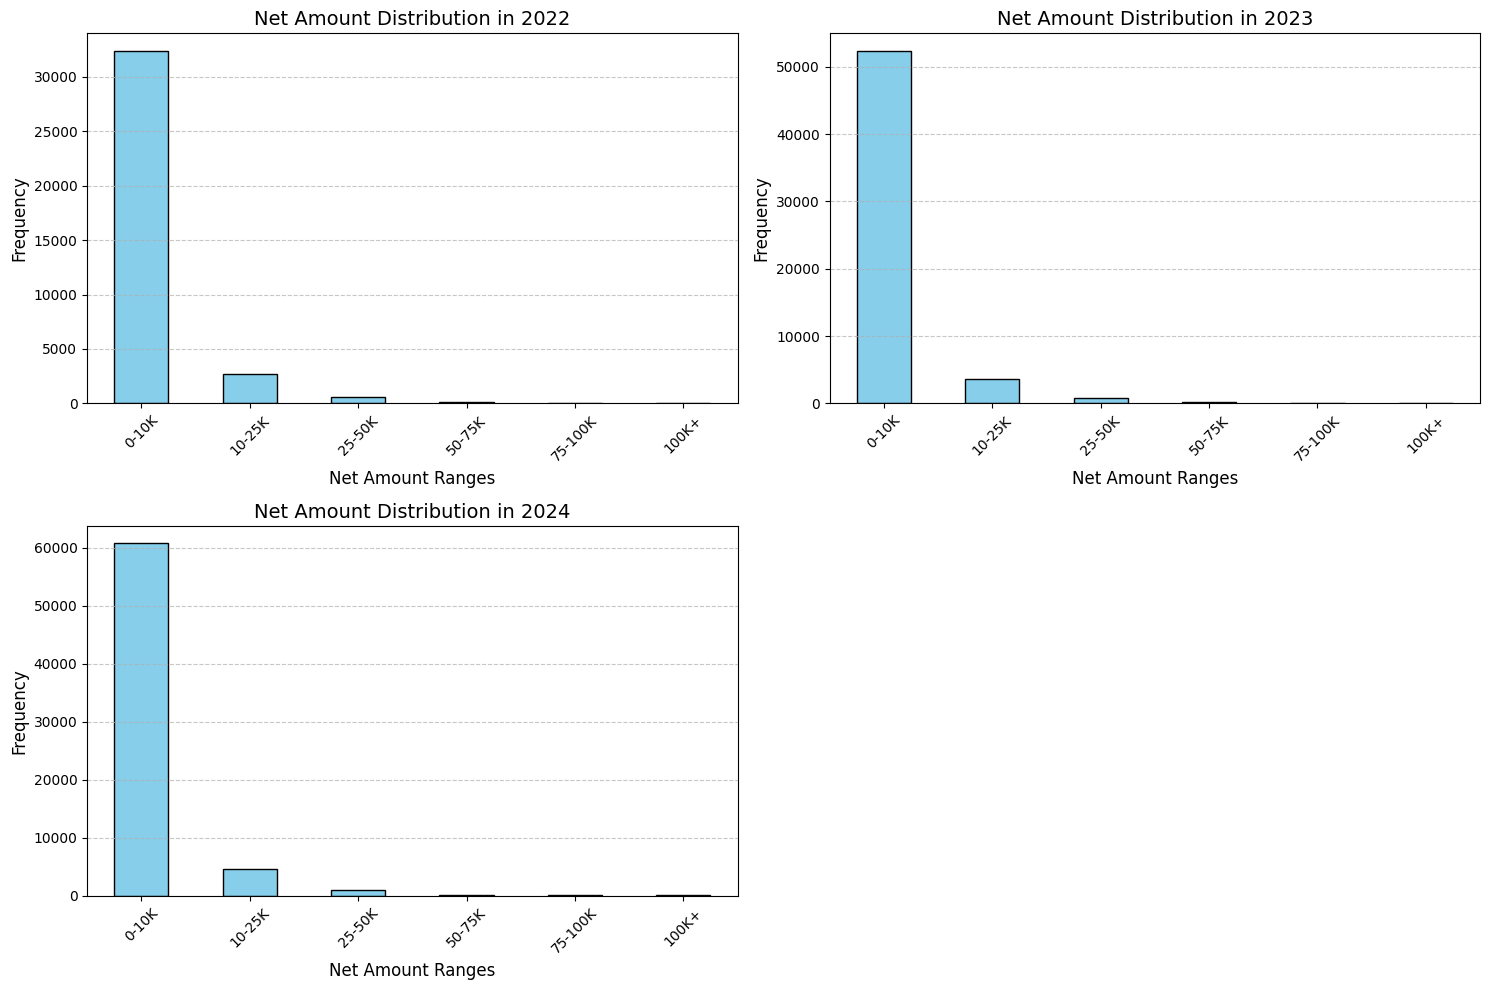

In [23]:
import matplotlib.pyplot as plt

# Define bins and labels
bins = [0, 10000, 25000, 50000, 75000, 100000, float('inf')]
labels = ['0-10K', '10-25K', '25-50K', '50-75K', '75-100K', '100K+']

# Add bins to the DataFrame
augmented_invoices['amount_range'] = pd.cut(augmented_invoices['net_amount'], bins=bins, labels=labels, right=False)

# Extract the year from created_date
augmented_invoices['year'] = augmented_invoices['created_date'].dt.year

# List of years to filter
years = [2022, 2023, 2024]

# Plot histograms for each year
plt.figure(figsize=(15, 10))

for i, year in enumerate(years, 1):
    plt.subplot(2, 2, i)

    # Filter data for the current year
    year_data = augmented_invoices[augmented_invoices['year'] == year]

    # Plot histogram
    year_data['amount_range'].value_counts(sort=False).plot(kind='bar', color='skyblue', edgecolor='black')

    # Customize the plot
    plt.title(f'Net Amount Distribution in {year}', fontsize=14)
    plt.xlabel('Net Amount Ranges', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [24]:
# Group by year and amount_range, count the frequency
distribution_table = augmented_invoices.groupby(['year', 'amount_range']).size().unstack(fill_value=0).reset_index()

# Rename columns for clarity
distribution_table.columns.name = None
distribution_table.columns = ['Year'] + list(distribution_table.columns[1:])  # Renaming only Net Amount Ranges

# Display the table
distribution_table

/var/folders/qb/xbnd03px51d29s05_x737l140000gn/T/ipykernel_30524/3807548463.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution_table = augmented_invoices.groupby(['year', 'amount_range']).size().unstack(fill_value=0).reset_index()


,Year,0-10K,10-25K,25-50K,50-75K,75-100K,100K+
0,2022,32348,2702,623,154,62,48
1,2023,52346,3618,866,205,83,80
2,2024,60762,4657,1065,236,96,118
